# Prueba de Yolo8 con Keras-Core

Basado en 
* [Keras Core: Keras for TensorFlow, JAX, and PyTorch](https://keras.io/keras_core/)
* [Efficient Object Detection with YOLOV8 and KerasCV](https://keras.io/examples/vision/yolov8/)

**Mariano Rivera**

Agosto 2023

V1.0

[Versión en python](test_yolo8.py)

In [1]:
import numpy as np
import keras_core as keras
import keras_cv
from keras_cv import visualization

import matplotlib.pyplot as plt

Using TensorFlow backend


2023-08-09 19:22:45.905668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 19:22:46.421628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mariano/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Imagen de prueba

(-0.5, 4031.5, 3023.5, -0.5)

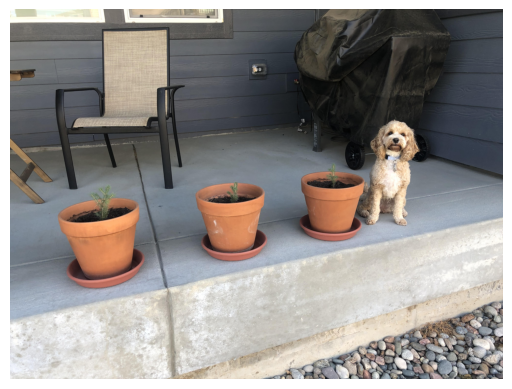

In [2]:
filepath  = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image     = np.array(keras.utils.load_img(filepath))

plt.imshow(image)
plt.axis('off')

## Preprocesamieto

Redimensionamiento (resizing) de la imagen usando keras-core, mantenemos la razón de aspecto, completamos con 0's la imagen y obtenemos un lote (batch) con una imagen.

In [3]:
inference_resizing = keras_cv.layers.Resizing(640, 640, 
                                              pad_to_aspect_ratio=True, 
                                              bounding_box_format="xywh")
image_resized = inference_resizing([image])
image_resized.shape

2023-08-09 19:22:49.088497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 19:22:49.109642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 19:22:49.109817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

TensorShape([1, 640, 640, 3])

Las clases que detectaremos son las 20 definidas en [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/ )

Creamos un diccionario de la forma 
```python
{id (int) : nombre (str)}
```

In [4]:
class_ids = ["Aeroplane",
             "Bicycle",
             "Bird",
             "Boat",
             "Bottle",
             "Bus",
             "Car",
             "Cat",
             "Chair",
             "Cow",
             "Dining Table",
             "Dog",
             "Horse",
             "Motorbike",
             "Person",
             "Potted Plant",
             "Sheep",
             "Sofa",
             "Train",
             "Tvmonitor",
             "Total",]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

## Modelo preentrenado

Usaremos formato de los rectangulos de detección (*bounding boxes*) de coordenadas en pixeles de la esquina superior izquierda ($x,y$),  ancho ($w$) y alto ($h$).

In [5]:
YOLO = False
if YOLO:
    model = keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_m_pascalvoc",
                                                   bounding_box_format="xywh",)
else:
    model = keras_cv.models.RetinaNet.from_preset("retinanet_resnet50_pascalvoc", 
                                                   bounding_box_format="xywh")    

Definimos parámetros del detector Yolo.

In [6]:
threshold     = 0.6
iou_threshold = 0.5

prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(bounding_box_format = "xywh",
                                                                 from_logits         = True,
                                                                 iou_threshold       = iou_threshold,
                                                                 confidence_threshold= threshold,)
model.prediction_decoder = prediction_decoder

## Inferencia (predicción)

In [7]:
predictions = model.predict(image_resized)

2023-08-09 19:22:53.796211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-09 19:22:53.851814: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-09 19:22:53.852321: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-09 19:22:53.852341: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-09 19:22:53.852821: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-09 19:22:53.852869: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

1/1 [==============================] - 3s 3s/step


## Visualización de resultados

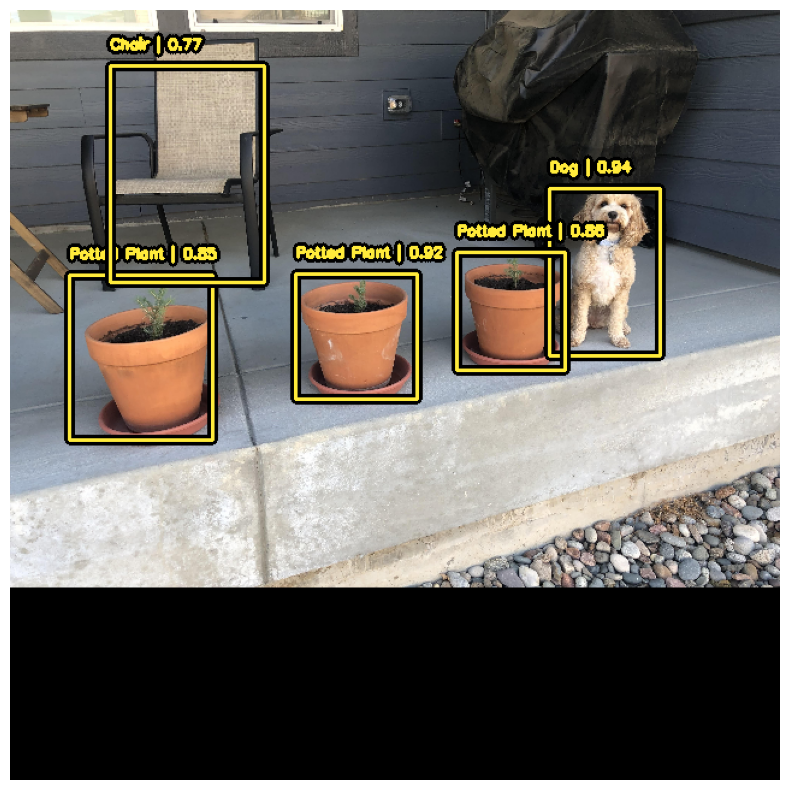

In [8]:
visualization.plot_bounding_box_gallery(image_resized,
                                        value_range   = (0, 255),
                                        rows          = 1,
                                        cols          = 1,
                                        y_pred        = predictions,
                                        scale         = 8,
                                        font_scale    = 0.4,
                                        bounding_box_format="xywh",
                                        class_mapping=class_mapping,
                                    )